In [ ]:
!pip install -q seaborn

In [ ]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import tempfile
import os
# Установим по умолчанию размер фигуры для Matplotlib по умолчанию.
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
train_data, val_data, test_data = tfds.load("fashion_mnist",
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            batch_size=128, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.M3BKOB_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.M3BKOB_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


## Fashion MNIST: Это набор данных, который состоит из 28x28 черно-белых изображений одежды и обуви

Размерность исходных данных: (48000, 28, 28, 1)


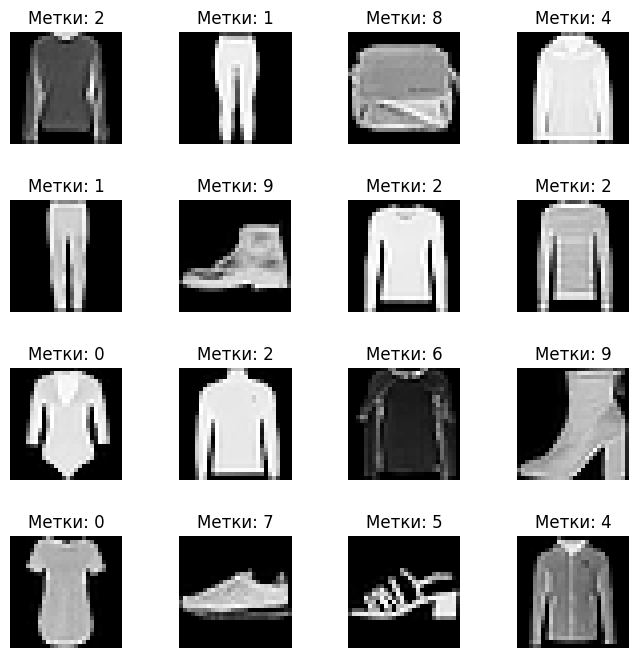

In [ ]:
x_viz, y_viz = tfds.load("fashion_mnist", split=['train[:80%]'], batch_size=-1, as_supervised=True)[0]
print('Размерность исходных данных:', x_viz.shape)

# Выводим 16 картинок из датасета
plt.figure(figsize=(8, 8))  # Устанавливаем размер фигуры
for i in range(16):
    plt.subplot(4, 4, 1 + i)
    plt.axis('off')
    plt.imshow(x_viz[i], cmap='gray')  # Отображение массива numpy как картинки в градациях серого
    plt.title(f"Метки: {y_viz[i].numpy()}")  # Преобразуем метки в numpy для отображения
    plt.subplots_adjust(hspace=.5, wspace=.5)  # Отступы по ширине и высоте между картинками

plt.show()  # Показываем все изображения


В CIFAR-10 классы изображений представлены следующими категориями:
- 0: Футболка/топ
- 1: Брюки
- 2: Свитер
- 3: Платье
- 4: Пальто
- 5: Сандалии
- 6: Рубашка
- 7: Кроссовки
- 8: Сумка
- 9: Ботинки

<ipython-input-9-567e0ccb8b52>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_viz.numpy(), palette='Set2')


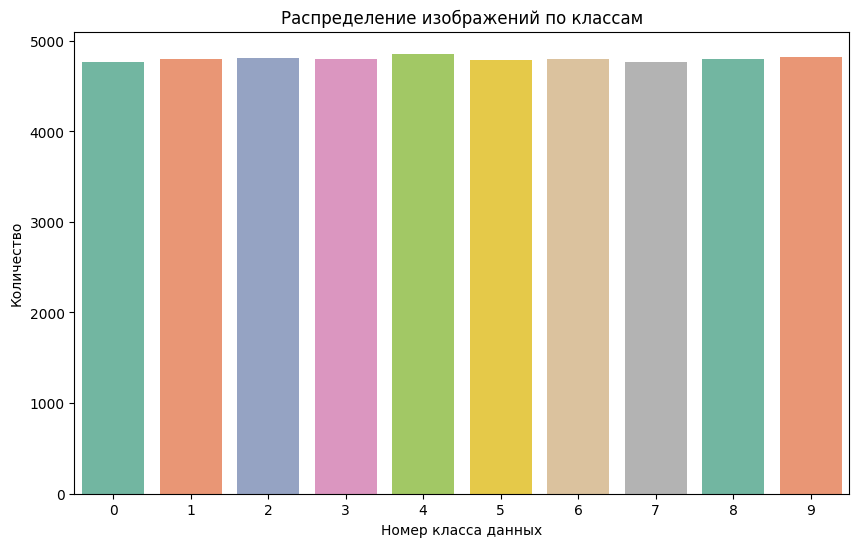

In [ ]:
# Создаем график распределения классов
plt.figure(figsize=(10, 6))
sns.countplot(x=y_viz.numpy(), palette='Set2')
plt.xlabel('Номер класса данных')
plt.ylabel('Количество')
plt.title("Распределение изображений по классам")

# Добавляем метки классов на ось x
plt.xticks(ticks=range(10))

plt.show()

In [ ]:
def preprocess(x, y):
    """Функция изменения формы и масштабирования данных"""
    # reshap - изменяет форму данных
    x = tf.reshape(x, shape=(-1, 784))  # -1 - значит сохранить форму для заданного индекса матрицы, равносильно указать 1500
    # Масштабируем данные
    x = x / 255
    return x, y

# Применяем функцию preprocess к данным
train_data = train_data.map(preprocess)
val_data = val_data.map(preprocess)

$$W_{ij} \sim \text{Uniform}(-\frac{\sqrt{6}}{\sqrt{n + m}},\frac{\sqrt{6}}{\sqrt{n + m}})$$


In [ ]:
def xavier_init(shape):
    # Вычисляем значения инициализации xavier для весовой матрицы
    in_dim, out_dim = shape
    # Задаем диапазон инициализации весов по схеме Ксавье
    xavier_lim = tf.sqrt(6.) / tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
    # Возвращаем тензор с равномерно распределенными случайными величинами в указанном интервале.
    weight_vals = tf.random.uniform(shape=(in_dim, out_dim), minval=-xavier_lim, maxval=xavier_lim)

    return weight_vals

## Класс полносвязанного слоя

In [ ]:
class DenseLayer(tf.Module):
    def __init__(self, out_dim, weight_init=xavier_init, activation=tf.identity):
        """Инициализация размеров и функции активации"""
        self.out_dim = out_dim  # Определяем размерность выходов
        self.weight_init = weight_init  # Инициализируем веса
        self.activation = activation  # Задаем функцию активации
        self.built = False

    @tf.function
    def __call__(self, x):
        if not self.built:  # Если запущен первый раз проводим инициализацию
            # Вывод входного измерения на основе первого вызова
            self.in_dim = x.shape[1]
            # Инициализация весов и смещений
            self.w = tf.Variable(self.weight_init(shape=(self.in_dim, self.out_dim)))  # Объявление тензорных переменных
            self.b = tf.Variable(tf.zeros(shape=(self.out_dim,)))  # Объявление тензорных переменных
            self.built = True  # Инициализация пройдена
        # Вычисление прямого прохода
        y = tf.add(tf.matmul(x, self.w), self.b)  # уравнение персептрона

        return self.activation(y)  # Применение функции активации к уравнению персептрона

## Класс для модели MLP

In [ ]:
class MLP(tf.Module):

  def __init__(self, layers):
    self.layers = layers

  @tf.function # Декоратор, который переносит вычисления на уровень графа TensorFlow
  def __call__(self, x, preds=False):
    # Последовательное выполнение слоев модели
    for layer in self.layers:
      x = layer(x)
    return x

# Нейронная сеть в 3 слоя

In [ ]:
hidden_layer_1_size = 700
hidden_layer_2_size = 500
output_size = 10

# Создание модели нейронной сети
mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])

### Определение функции потерь
$$L = -\frac{1}{n}\sum_{i=1}^{n}\sum_{i=j}^{n} {y_j}^{[i]}⋅\log(\hat{{y_j}}^{[i]})$$

In [ ]:
def cross_entropy_loss(y_pred, y):
    # Вычисление перекрестной энтропии с помощью разреженной операции
    sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
    return tf.reduce_mean(sparse_ce)  # аналог np.mean для тензоров

## Функция вычисления точности, которая определяет долю правильных классификаций во время обучения

In [ ]:
def accuracy(y_pred, y):
    # Вычисляем точность после извлечения предсказаний класса
    class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1)  # возвращает индекс максимального элемента
    is_equal = tf.equal(y, class_preds)  # сравнение тензорных значений
    return tf.reduce_mean(tf.cast(is_equal, tf.float32))  # аналог np.mean для тензоров

## Алгоритм оптимизации Adam

In [ ]:
class Adam:
    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
        # Инициализируем параметры оптимизатора и резервируем переменные
        self.beta_1 = beta_1  # гиперпараметр
        self.beta_2 = beta_2  # гиперпараметр
        self.learning_rate = learning_rate  # шаг обучения
        self.ep = ep  # Эпсилон - предотвращает деление на ноль, слабо влияет на обучение
        self.t = 1.
        self.v_dvar, self.s_dvar = [], []
        self.built = False

    def apply_gradients(self, grads, vars):
        # Инициализируем переменные при первом вызове
        if not self.built:
            for var in vars:
                v = tf.Variable(tf.zeros(shape=var.shape))
                s = tf.Variable(tf.zeros(shape=var.shape))
                self.v_dvar.append(v)
                self.s_dvar.append(s)
            self.built = True
        # Обновите переменные модели с учетом их градиентов
        for i, (d_var, var) in enumerate(zip(grads, vars)):
            self.v_dvar[i].assign(self.beta_1 * self.v_dvar[i] + (1 - self.beta_1) * d_var)
            self.s_dvar[i].assign(self.beta_2 * self.s_dvar[i] + (1 - self.beta_2) * tf.square(d_var))
            v_dvar_bc = self.v_dvar[i] / (1 - (self.beta_1 ** self.t))
            s_dvar_bc = self.s_dvar[i] / (1 - (self.beta_2 ** self.t))
            var.assign_sub(self.learning_rate * (v_dvar_bc / (tf.sqrt(s_dvar_bc) + self.ep)))
        self.t += 1.
        return

In [ ]:
def train_step(x_batch, y_batch, loss, acc, model, optimizer):
    # Обновляем состояние модели с учетом пакета данных
    with tf.GradientTape() as tape:
        y_pred = model(x_batch)  # Предсказываем значение с текущими весами
        batch_loss = loss(y_pred, y_batch)  # Оцениваем ошибку на текущих весах
        batch_acc = acc(y_pred, y_batch)  # Оцениваем точность на текущих весах
        grads = tape.gradient(batch_loss, model.variables)  # Вычисляем градиенты
        optimizer.apply_gradients(grads, model.variables)  # Обновляем переменные с учетом полученных градиентов
    return batch_loss, batch_acc  # Возвращаем ошибку и точность на основе заданного пакета

def val_step(x_batch, y_batch, loss, acc, model):
    # Оцениваем модель на основе заданного пакета валидационных данных без обучения на текущих весах
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
    batch_acc = acc(y_pred, y_batch)
    return batch_loss, batch_acc

In [ ]:
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
    # Инициализация структур данных
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    # Отформатируем тренировочный цикл и начнем обучение
    for epoch in range(epochs):
        batch_losses_train, batch_accs_train = [], []
        batch_losses_val, batch_accs_val = [], []

        # Выполняем итерацию по обучающим данным
        for x_batch, y_batch in train_data:
            # Вычисляем градиенты и обновляем параметры модели
            batch_loss, batch_acc = train_step(x_batch, y_batch, loss, acc, mlp, optimizer)
            # Следим за результатами обучения на пакетном уровне
            batch_losses_train.append(batch_loss)
            batch_accs_train.append(batch_acc)

        # Повторяем процедуру проверки данных
        for x_batch, y_batch in val_data:
            batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
            batch_losses_val.append(batch_loss)
            batch_accs_val.append(batch_acc)

        # Следим за производительностью модели на уровне эпохи
        train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
        val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"Эпоха: {epoch}")
        print(f"Обучающая ошибка: {train_loss:.3f}, Обучающая точность: {train_acc:.3f}")
        print(f"Валидационная ошибка: {val_loss:.3f}, Валидационная точность: {val_acc:.3f}")
    return train_losses, train_accs, val_losses, val_accs

In [59]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data,
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=10)

Эпоха: 0
Обучающая ошибка: 0.498, Обучающая точность: 0.818
Валидационная ошибка: 0.433, Валидационная точность: 0.838
Эпоха: 1
Обучающая ошибка: 0.367, Обучающая точность: 0.865
Валидационная ошибка: 0.357, Валидационная точность: 0.871
Эпоха: 2
Обучающая ошибка: 0.330, Обучающая точность: 0.878
Валидационная ошибка: 0.338, Валидационная точность: 0.879
Эпоха: 3
Обучающая ошибка: 0.304, Обучающая точность: 0.886
Валидационная ошибка: 0.357, Валидационная точность: 0.866
Эпоха: 4
Обучающая ошибка: 0.281, Обучающая точность: 0.895
Валидационная ошибка: 0.339, Валидационная точность: 0.880
Эпоха: 5
Обучающая ошибка: 0.265, Обучающая точность: 0.900
Валидационная ошибка: 0.334, Валидационная точность: 0.885
Эпоха: 6
Обучающая ошибка: 0.252, Обучающая точность: 0.905
Валидационная ошибка: 0.368, Валидационная точность: 0.878
Эпоха: 7
Обучающая ошибка: 0.242, Обучающая точность: 0.909
Валидационная ошибка: 0.340, Валидационная точность: 0.889
Эпоха: 8
Обучающая ошибка: 0.227, Обучающая точн

### Оценка производительности

In [ ]:
def plot_metrics(train_metric, val_metric, metric_type):
  # Визуализация метрик в зависимости от эпох обучения
  plt.figure()
  plt.plot(range(len(train_metric)), train_metric, label = f"{metric_type} на обучающей выборке")
  plt.plot(range(len(val_metric)), val_metric, label = f"{metric_type} на валидационной выборке")
  plt.xlabel("Эпохи")
  plt.ylabel(metric_type)
  plt.legend()
  plt.title(f"{metric_type} от эпохи");

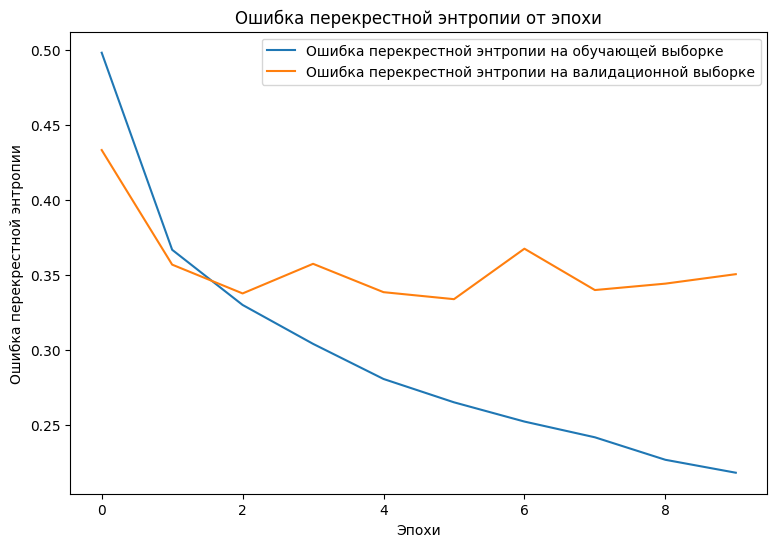

In [60]:
plot_metrics(train_losses, val_losses, "Ошибка перекрестной энтропии")

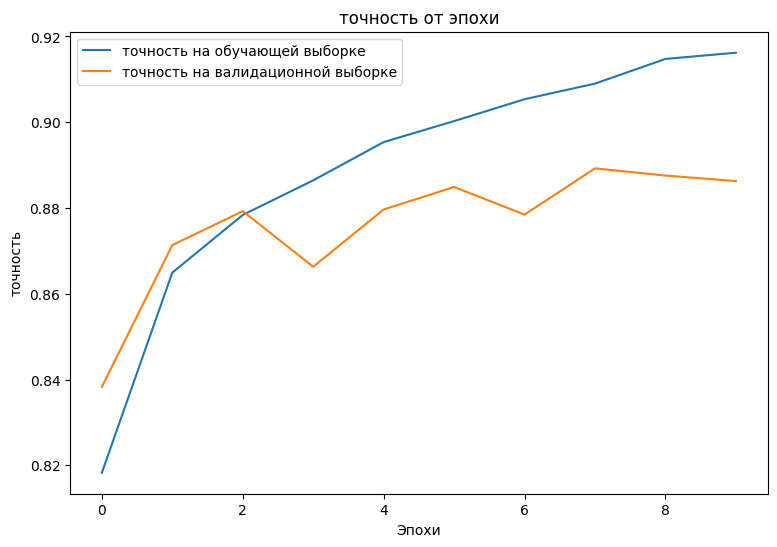

In [61]:
plot_metrics(train_accs, val_accs, "точность")

## Сохранение и загрузка модели

Точность на тестовой выборке: 0.883
Точность с разбивкой по цифрам :
---------------------------
Цифра 6: 0.643
Цифра 4: 0.811
Цифра 2: 0.823
Цифра 0: 0.848
Цифра 3: 0.882
Цифра 5: 0.954
Цифра 7: 0.959
Цифра 9: 0.962
Цифра 1: 0.968
Цифра 8: 0.979


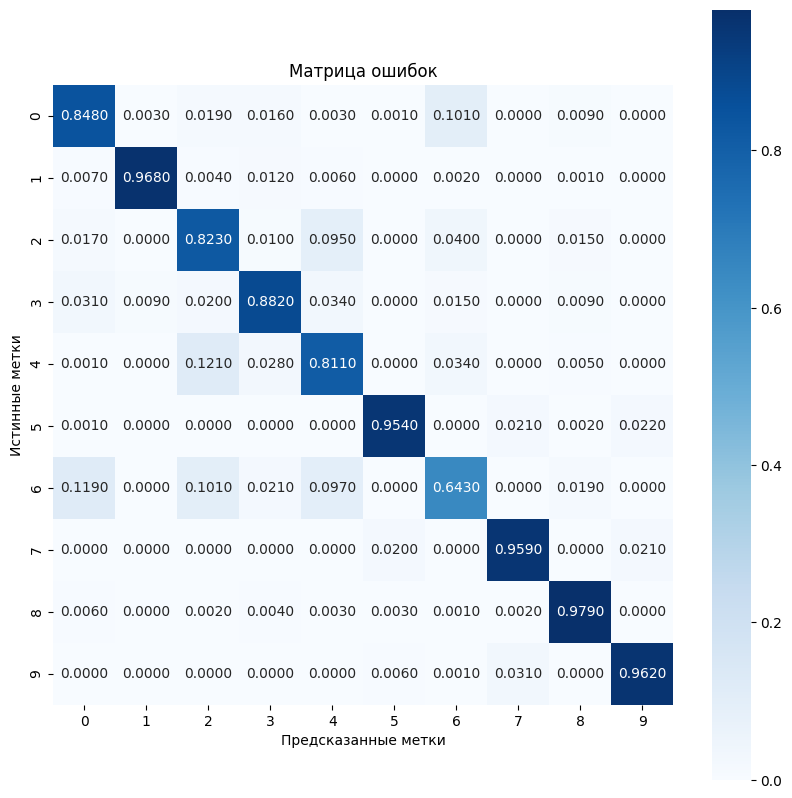

In [62]:
mlp_model_export = ExportModule(model=mlp_model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

models = tempfile.mkdtemp()
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)

mlp_loaded = tf.saved_model.load(save_path)

def accuracy_score(y_pred, y):
    # Общая функция точности
    is_equal = tf.equal(y_pred, y)
    return tf.reduce_mean(tf.cast(is_equal, tf.float32))

x_test, y_test = tfds.load("fashion_mnist", split=['test'], batch_size=-1, as_supervised=True)[0]
test_classes = mlp_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Точность на тестовой выборке: {test_acc:.3f}")

print("Точность с разбивкой по цифрам :")
print("---------------------------")
label_accs = {}
for label in range(10):
    label_ind = (y_test == label)

    pred_label = test_classes[label_ind]
    labels = y_test[label_ind]

    label_accs[accuracy_score(pred_label, labels).numpy()] = label
for key in sorted(label_accs):
    print(f"Цифра {label_accs[key]}: {key:.3f}")

import sklearn.metrics as sk_metrics

def show_confusion_matrix(test_labels, test_classes):
    # Вычисление матрицы ошибок и ее нормализация
    plt.figure(figsize=(10, 10))
    confusion = sk_metrics.confusion_matrix(test_labels.numpy(), test_classes.numpy())
    confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
    axis_labels = range(10)
    ax = sns.heatmap(
        confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='.4f', square=True)
    plt.title("Матрица ошибок")
    plt.ylabel("Истинные метки")
    plt.xlabel("Предсказанные метки")
    plt.show()

show_confusion_matrix(y_test, test_classes)

# Нейронная сеть в 4 слоя


In [54]:
# Добавляем дополнительные слои
hidden_layer_1_size = 700
hidden_layer_2_size = 500
hidden_layer_3_size = 300
hidden_layer_4_size = 200
output_size = 10

# Создание модели нейронной сети с дополнительными слоями
mlp_model2 = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_3_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_4_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])

In [55]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model2, train_data, val_data,
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=10)

Эпоха: 0
Обучающая ошибка: 0.501, Обучающая точность: 0.818
Валидационная ошибка: 0.431, Валидационная точность: 0.844
Эпоха: 1
Обучающая ошибка: 0.365, Обучающая точность: 0.864
Валидационная ошибка: 0.358, Валидационная точность: 0.870
Эпоха: 2
Обучающая ошибка: 0.326, Обучающая точность: 0.879
Валидационная ошибка: 0.342, Валидационная точность: 0.875
Эпоха: 3
Обучающая ошибка: 0.300, Обучающая точность: 0.888
Валидационная ошибка: 0.343, Валидационная точность: 0.879
Эпоха: 4
Обучающая ошибка: 0.281, Обучающая точность: 0.894
Валидационная ошибка: 0.347, Валидационная точность: 0.877
Эпоха: 5
Обучающая ошибка: 0.265, Обучающая точность: 0.901
Валидационная ошибка: 0.336, Валидационная точность: 0.882
Эпоха: 6
Обучающая ошибка: 0.251, Обучающая точность: 0.905
Валидационная ошибка: 0.341, Валидационная точность: 0.885
Эпоха: 7
Обучающая ошибка: 0.240, Обучающая точность: 0.908
Валидационная ошибка: 0.337, Валидационная точность: 0.884
Эпоха: 8
Обучающая ошибка: 0.229, Обучающая точн

# Оценка производительности

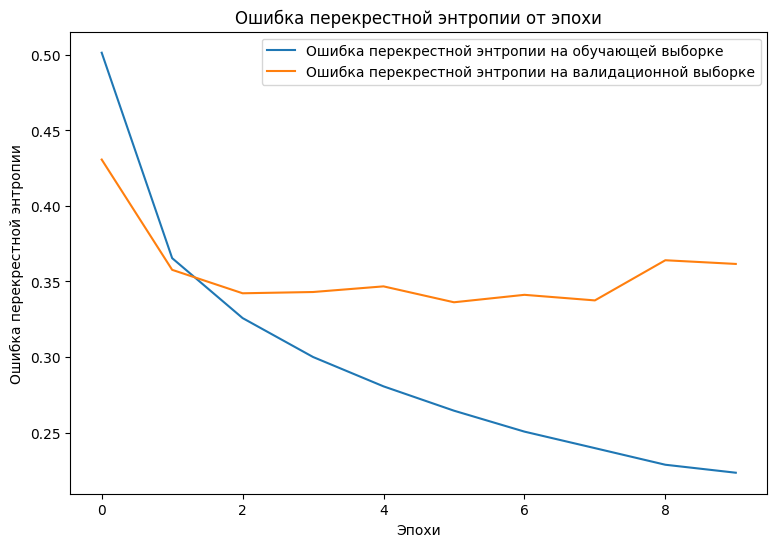

In [56]:
plot_metrics(train_losses, val_losses, "Ошибка перекрестной энтропии")

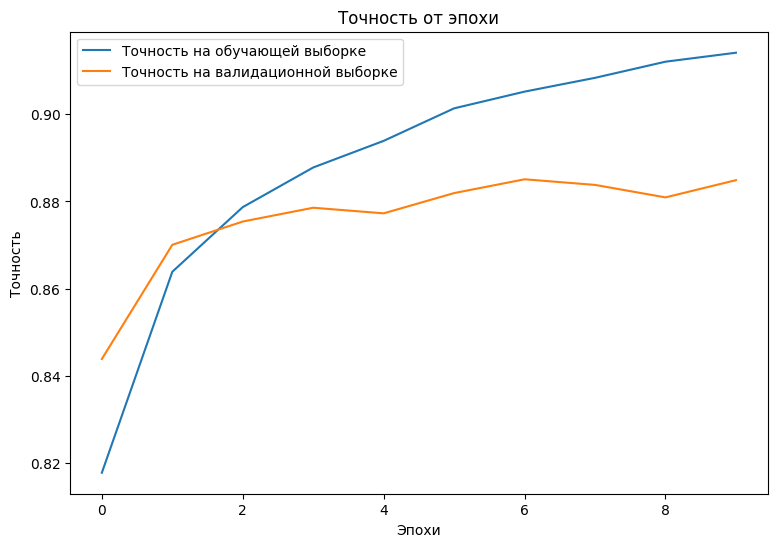

In [57]:
plot_metrics(train_accs, val_accs, "Точность")

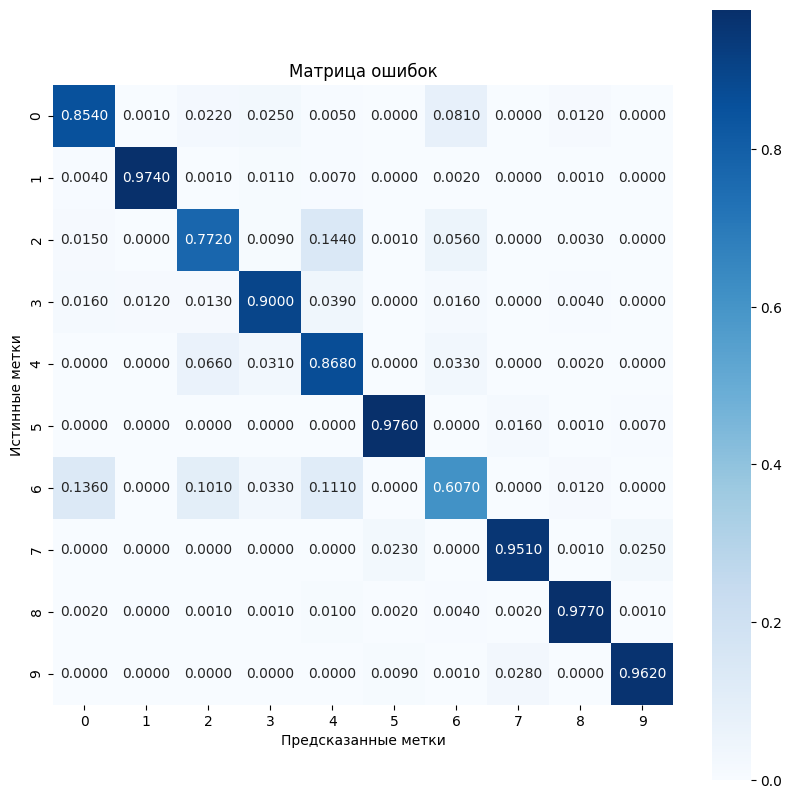

In [58]:
show_confusion_matrix(y_test, test_classes)